In [210]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn.model_selection as skm
from sklearn.metrics import accuracy_score, precision_score,recall_score

In [212]:
ECG = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv',header=None)
print(ECG.head())

        0         1         2         3         4         5         6    \
0 -0.112522 -2.827204 -3.773897 -4.349751 -4.376041 -3.474986 -2.181408   
1 -1.100878 -3.996840 -4.285843 -4.506579 -4.022377 -3.234368 -1.566126   
2 -0.567088 -2.593450 -3.874230 -4.584095 -4.187449 -3.151462 -1.742940   
3  0.490473 -1.914407 -3.616364 -4.318823 -4.268016 -3.881110 -2.993280   
4  0.800232 -0.874252 -2.384761 -3.973292 -4.338224 -3.802422 -2.534510   

        7         8         9    ...       131       132       133       134  \
0 -1.818287 -1.250522 -0.477492  ...  0.792168  0.933541  0.796958  0.578621   
1 -0.992258 -0.754680  0.042321  ...  0.538356  0.656881  0.787490  0.724046   
2 -1.490658 -1.183580 -0.394229  ...  0.886073  0.531452  0.311377 -0.021919   
3 -1.671131 -1.333884 -0.965629  ...  0.350816  0.499111  0.600345  0.842069   
4 -1.783423 -1.594450 -0.753199  ...  1.148884  0.958434  1.059025  1.371682   

        135       136       137       138       139  140  
0  0.2577

In [213]:
print(ECG.shape)

(4998, 141)


In [214]:
ECG5000_data = ECG.values 
ECG_label = ECG5000_data[:, -1]   #读取标签
ECG_data = ECG5000_data[:,0:-1]  #读取数据

In [215]:
train_data, test_data, train_label, test_label = skm.train_test_split(ECG_data, ECG_label,test_size=0.3)

In [217]:
min_data = tf.reduce_min(train_data)
max_data = tf.reduce_max(train_data)
train_data = (train_data - min_data) / (max_data - min_data)
test_data = (test_data - min_data) / (max_data - min_data)
train_data = tf.cast(train_data, tf.float64)
test_data = tf.cast(test_data, tf.float64)

In [218]:
train_label = train_label.astype(bool)
test_label = test_label.astype(bool)
normal_train_data = train_data[train_label]  #选出正常的用于训练
normal_test_data = test_data[test_label]
ano_train_data = train_data[~train_label] #选出异常的
ano_test_data = test_data[~test_label]

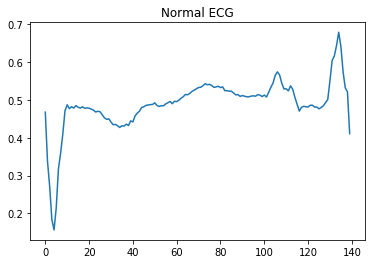

In [219]:
plt.plot(np.arange(140), normal_train_data[0])
plt.title("Normal ECG")
plt.show()

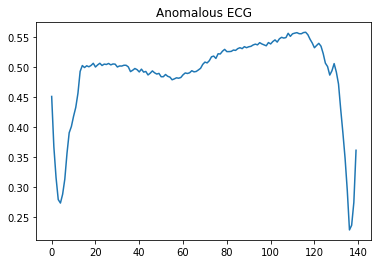

In [220]:
plt.plot(np.arange(140), ano_train_data[0])
plt.title("Anomalous ECG")
plt.show()

In [221]:
class Autoencoder(tf.keras.Model):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = tf.keras.Sequential([
          tf.keras.layers.Dense(64, activation="relu"),
          tf.keras.layers.Dense(32, activation="relu"),
          tf.keras.layers.Dense(16, activation="relu")])

        self.decoder = tf.keras.Sequential([
          tf.keras.layers.Dense(32, activation="relu"),
          tf.keras.layers.Dense(64, activation="relu"),
          tf.keras.layers.Dense(140, activation="sigmoid")])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = Autoencoder()

In [222]:
autoencoder.compile(optimizer='Adam', loss='MAE')
history = autoencoder.fit(normal_train_data, normal_train_data, epochs=20, batch_size=256, validation_data=(test_data, test_data), shuffle=True)

Epoch 1/20
8/8 [==============================] - 1s 63ms/step - loss: 0.0469 - val_loss: 0.0432
Epoch 2/20
8/8 [==============================] - 0s 18ms/step - loss: 0.0427 - val_loss: 0.0408
Epoch 3/20
8/8 [==============================] - 0s 21ms/step - loss: 0.0375 - val_loss: 0.0388
Epoch 4/20
8/8 [==============================] - 0s 17ms/step - loss: 0.0328 - val_loss: 0.0370
Epoch 5/20
8/8 [==============================] - 0s 17ms/step - loss: 0.0289 - val_loss: 0.0354
Epoch 6/20
8/8 [==============================] - 0s 18ms/step - loss: 0.0254 - val_loss: 0.0342
Epoch 7/20
8/8 [==============================] - 0s 17ms/step - loss: 0.0238 - val_loss: 0.0327
Epoch 8/20
8/8 [==============================] - 0s 18ms/step - loss: 0.0220 - val_loss: 0.0317
Epoch 9/20
8/8 [==============================] - 0s 13ms/step - loss: 0.0208 - val_loss: 0.0307
Epoch 10/20
8/8 [==============================] - 0s 16ms/step - loss: 0.0197 - val_loss: 0.0304
Epoch 11/20
8/8 [============

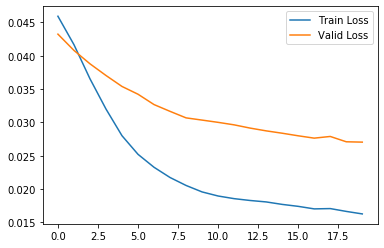

In [223]:
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Valid Loss")
plt.legend()


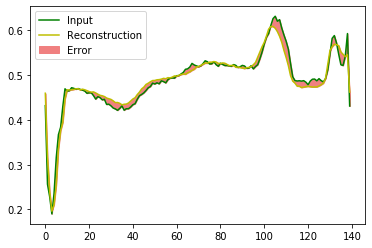

In [224]:
encoded_data = autoencoder.encoder(normal_test_data).numpy()   #编码正常测试数据
decoded_data = autoencoder.decoder(encoded_data).numpy()   #解码数据
plt.plot(normal_test_data[0],'g')
plt.plot(decoded_data[0],'y')
#查看二者差异
plt.fill_between(np.arange(140), decoded_data[0], normal_test_data[0], color='lightcoral' )
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

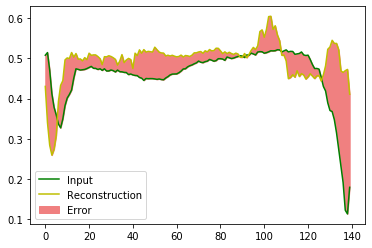

In [225]:
encoded_data = autoencoder.encoder(anomalous_test_data).numpy()   #编码异常测试数据
decoded_data = autoencoder.decoder(encoded_data).numpy()   #解码数据
plt.plot(anomalous_test_data[0],'g')
plt.plot(decoded_data[0],'y')
#查看二者差异
plt.fill_between(np.arange(140), decoded_data[0], anomalous_test_data[0], color='lightcoral' )
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()